In [ ]:
#kjør
import scipy
import sklearn
#import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import math as m
import pandas as pd
import os
import librosa
from scipy import signal, ndimage
from scipy.io.wavfile import read
from scipy.signal import periodogram
from scipy.ndimage import median_filter
from matplotlib import pyplot
from numpy import trapz
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import tensorflow
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from tqdm import tqdm
from python_speech_features import mfcc
from python_speech_features import delta
import pickle
from google.colab import drive ## If running on google colab

In [ ]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=0f372ad72ca82e8c1b6bebe9604c45ec4630b084dc2364f0c560fb61e084d440
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
drive.mount('/content/drive/') #IF Using google collab

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


PREPROCESSING

In [ ]:
#kjør
from scipy.io import wavfile
import scipy.signal as sps
def preprocess_cough(x,fs, cutoff = 6000, normalize = True, filter_ = True, downsample = True):
  """
  Normalize, lowpass filter, and downsample cough samples in a given data folder 
  
  Inputs: x*: (float array) time series cough signal
  fs*: (int) sampling frequency of the cough signal in Hz
  cutoff: (int) cutoff frequency of lowpass filter
  normalize: (bool) normailzation on or off
  filter: (bool) filtering on or off
  downsample: (bool) downsampling on or off
  *: mandatory input
  
  Outputs: x: (float32 array) new preprocessed cough signal
  fs: (int) new sampling frequency
  """
  
  fs_downsample = cutoff*2
  
  #Preprocess Data
  if len(x.shape)>1:
    x = np.mean(x,axis=1)                          # Convert to mono
  if normalize:
    x = x/(np.max(np.abs(x))+1e-17)                # Norm to range between -1 to 1
  if filter_:
    b, a = butter(4, fs_downsample/fs, btype='lowpass') # 4th order butter lowpass filter
    x = filtfilt(b, a, x)
  if downsample:
    #x = scipy.signal.decimate(x, int(fs/fs_downsample)) # Downsample for anti-aliasing
    #x, s = librosa.load(x, sr=20000) # Downsample 44.1kHz to 8kHz
    number_of_samples = round(len(x) * float(20000) / 48000)
    x = sps.resample(x, number_of_samples)
  
  fs_new = fs_downsample

  return np.float32(x), fs_new

In [ ]:
#kjør
def segment_cough(x,fs, cough_padding=0.1,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

In [ ]:

import csv

ver='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/created_csv/file.csv'
with open(ver, 'rt') as f:
    reader = csv.reader(f)
    verified_data = list(reader)

FEATURE EXTRACTION

In [ ]:
from scipy.signal import butter,filtfilt
from python_speech_features import mfcc
from python_speech_features import delta
directory='/content/drive/MyDrive/Colab Notebooks/ORGANIZE/balanced_data/'
sum=0
mean_length=0
#f_down=24000
concat_feat=[]
q=0
features_list=[]
win_len=0.01
labelVector=[]
COVID=1
HEALTHY=0
s=0
segment=[]
all_segments=[]
index_name=verified_data[0].index('uuid')
index_status=verified_data[0].index('status')
for filename in os.listdir(directory):
  segment=[]
  all_segments=[]
  #fs, signal = scipy.io.wavfile.read(directory+filename)
  signal,sr=librosa.load(directory+filename,sr =20000)
  #signal_pre=2.*(signal - np.min(signal))/np.ptp(signal)-1
  #signal_pre,fs_pre=preprocess_cough(signal,fs=sr, cutoff = 10000, normalize = True, filter_ =False, downsample = False)
  signal_pre=signal
  segment,mask=segment_cough(signal_pre,fs_pre,cough_padding=0.1,min_cough_len=0.1, th_l_multiplier = 0.1, th_h_multiplier = 2)
  f_down=sr
  if len(segment)>1:
    for line in segment:
      all_segments=np.append(all_segments,line) #all the segments in one row from each file, one segment=one cough 
  elif len(segment)==1:
    all_segments=np.array(segment[0])
  if len(all_segments) < (f_down*0.5):
    missing_samples = int((f_down*0.5) - len(all_segments))
    all_segments = np.pad(all_segments, (0, missing_samples), "constant", constant_values=0)
  elif len(all_segments) > (f_down*0.5):
    all_segments = all_segments[: int(f_down*0.5)]
  mfcc_feat = mfcc(all_segments, f_down, numcep=26, nfft=4096, winlen=win_len, winstep=win_len/2)
  delta_feat = delta(mfcc_feat, 2)
  delta_delta_feat = delta(delta_feat, 2)
  concat_feat = np.concatenate((mfcc_feat, delta_feat, delta_delta_feat), axis=1)
  features_list.append(concat_feat)
  sum+=len(segment[0])/f_down
  for i in range(1,len(verified_data)):
    if verified_data[i][index_name]==filename[:36]:
      if verified_data[i][index_status]=='COVID-19':
        labelVector.append(COVID)
      elif verified_data[i][index_status]=='healthy':
        labelVector.append(HEALTHY)
  #print(sum)

mean_length=sum/len(os.listdir(directory))

In [ ]:
print(mean_length)
Featuress=np.array(features_list)
print(Featuress.shape)
print(len(labelVector))

0.546121402877698
(1390, 99, 78)
1390


In [ ]:
X_test=[]
X_train=[]
X_val=[]
y_test=[]
y_train=[]
y_val=[]
X_train, X_test, y_train, y_test = train_test_split(Featuress, labelVector, test_size=0.20, stratify=labelVector)
#Split into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

# scale the test dataset
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val=scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)



1390


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1112, 99, 78)
(139, 99, 78)
(139, 99, 78)


LSTM-model

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Conv2D, MaxPooling1D,MaxPool2D,Dropout,Activation, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow import keras
from tensorflow.keras import layers
X_train=np.array(X_train)
y_train=np.array(y_train)

X_val=np.array(X_val)
y_val=np.array(y_val)


In [ ]:
input_shape=(X_train.shape[1],X_train.shape[2])
#For coughvid features:
LSTM_model = Sequential()
LSTM_model.add(LSTM(32,input_shape=input_shape))
#for coughvid
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(32,activation='relu'))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model._name = 'lstm_model'
LSTM_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:

import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=25)
LSTM_model.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=64,epochs=100,callbacks=es)

Epoch 1/100
18/18 [==============================] - 3s 69ms/step - loss: 0.6994 - accuracy: 0.5099 - val_loss: 0.6999 - val_accuracy: 0.5180
Epoch 2/100
18/18 [==============================] - 1s 42ms/step - loss: 0.6786 - accuracy: 0.5701 - val_loss: 0.7011 - val_accuracy: 0.4820
Epoch 3/100
18/18 [==============================] - 1s 41ms/step - loss: 0.6619 - accuracy: 0.6133 - val_loss: 0.7036 - val_accuracy: 0.4820
Epoch 4/100
18/18 [==============================] - 1s 41ms/step - loss: 0.6514 - accuracy: 0.6268 - val_loss: 0.7065 - val_accuracy: 0.4748
Epoch 5/100
18/18 [==============================] - 1s 42ms/step - loss: 0.6329 - accuracy: 0.6835 - val_loss: 0.7088 - val_accuracy: 0.4748
Epoch 6/100
18/18 [==============================] - 1s 43ms/step - loss: 0.6095 - accuracy: 0.7140 - val_loss: 0.7125 - val_accuracy: 0.5108
Epoch 7/100
18/18 [==============================] - 1s 43ms/step - loss: 0.5890 - accuracy: 0.7293 - val_loss: 0.7169 - val_accuracy: 0.5180
Epoch 

              precision    recall  f1-score   support

     healthy       0.54      0.64      0.58        70
    COVID-19       0.55      0.43      0.48        69

    accuracy                           0.54       139
   macro avg       0.54      0.54      0.53       139
weighted avg       0.54      0.54      0.53       139



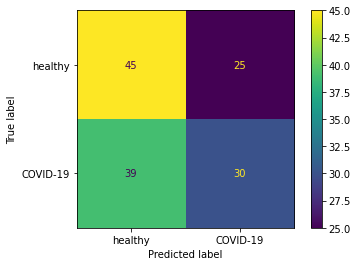

In [ ]:
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_LSTM=0
y_pred_LSTM=LSTM_model.predict(X_test)
y_pred_LSTM = (y_pred_LSTM > 0.5)
cm_LSTM = confusion_matrix(y_test,y_pred_LSTM)
display_labels=['healthy','COVID-19']
conf_matrix = confusion_matrix(y_test, y_pred_LSTM)
#print(Y_predict)
print(classification_report(y_test,y_pred_LSTM,target_names=display_labels))
print(ConfusionMatrixDisplay(cm_LSTM,display_labels=display_labels).plot(values_format='.0f'))

No Skill: ROC AUC=0.500
LSTM: ROC AUC=0.609


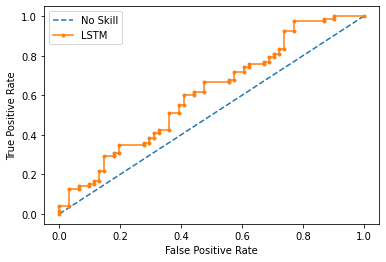

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]
# keep probabilities for the positive outcome only
y_pred_LSTM=LSTM_model.predict(X_test)
lr_probs= y_pred_LSTM
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LSTM: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LSTM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import f1_score,roc_auc_score
#plot_precision_recall_plot(LSTM_model,X_test,y_test)

In [ ]:
LSTM_model.save('mymodal_f3.h5')